In [1]:
# ============================================================
# 1. Install dan import library
# ============================================================
import os
from pathlib import Path
import numpy as np
import cv2
import kagglehub
from tqdm import tqdm

import matplotlib.pyplot as plt

from skimage.segmentation import active_contour
from skimage.filters import gaussian
from skimage.draw import polygon
from skimage.feature import graycomatrix, graycoprops
from scipy import ndimage as ndi

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score

# Untuk menghindari warning yang mengganggu
import warnings
warnings.filterwarnings("ignore")


In [2]:
# ============================================================
# 2. Download dataset TBX-11 dari Kaggle dengan kagglehub
# ============================================================

dataset_path = kagglehub.dataset_download("usmanshams/tbx-11")
print("Dataset path:", dataset_path)

# Lihat isi folder paling atas
print("Top-level files/folders:", os.listdir(dataset_path))


Using Colab cache for faster access to the 'tbx-11' dataset.
Dataset path: /kaggle/input/tbx-11
Top-level files/folders: ['TBX11K']


In [3]:
# ============================================================
# 3. Utilitas: cari semua path image dan buat label TB vs Non-TB
# ============================================================
# Di TBX11K biasanya kelasnya: Healthy, Sick but non-TB, Active TB, Latent TB, Uncertain TB.
# Kita ubah menjadi biner:
#    TB     : Active TB, Latent TB, Active&Latent TB
#    Non-TB : Healthy, Sick but non-TB
# Uncertain TB bisa di-skip.

IMAGE_EXTS = (".png", ".jpg", ".jpeg")

def list_all_images(root_dir):
    root = Path(root_dir)
    paths = []
    for p in root.rglob("*"):
        if p.suffix.lower() in IMAGE_EXTS:
            paths.append(str(p))
    return paths

def map_path_to_binary_label(path_str):
    """
    Mengembalikan:
      1 = TB
      0 = Non-TB
      None = tidak dipakai (misal Uncertain TB)
    Mapping dilakukan berdasarkan nama folder yang muncul di path.
    Sesuaikan jika nama folder di dataset kamu berbeda.
    """
    parts = [part.lower() for part in Path(path_str).parts]

    category = None

    for p in parts:
        if "uncertain" in p:
            category = "uncertain"
            break
        if "healthy" in p or "normal" in p:
            category = "healthy"
            break
        if "sick" in p and "tb" not in p:
            category = "sick_non_tb"
            break
        if "non-tb" in p or "nontb" in p:
            category = "sick_non_tb"
            break
        if "active" in p and "tb" in p:
            category = "active_tb"
            break
        if "latent" in p and "tb" in p:
            category = "latent_tb"
            break
        # fallback sangat kasar: kalau nama foldernya persis "tb"
        if p == "tb":
            category = "tb"
            break

    if category in ["active_tb", "latent_tb", "tb"]:
        return 1      # TB
    elif category in ["healthy", "sick_non_tb"]:
        return 0      # Non-TB
    else:
        return None   # tidak dipakai

all_image_paths = list_all_images(dataset_path)
print("Total image files ditemukan:", len(all_image_paths))

# Ubah ke list berisi (path, label_biner)
labeled_paths = []
for p in all_image_paths:
    label = map_path_to_binary_label(p)
    if label is not None:
        labeled_paths.append((p, label))

print("Total image yang dipakai setelah mapping TB vs Non-TB:", len(labeled_paths))

# Opsional: batasi jumlah per kelas supaya training cepat
MAX_PER_CLASS = 1200  # silakan naikkan kalau komputernya kuat

tb_paths = [p for p, y in labeled_paths if y == 1][:MAX_PER_CLASS]
nontb_paths = [p for p, y in labeled_paths if y == 0][:MAX_PER_CLASS]

paths_balanced = tb_paths + nontb_paths
labels_balanced = [1]*len(tb_paths) + [0]*len(nontb_paths)

print("Jumlah TB:", len(tb_paths))
print("Jumlah Non-TB:", len(nontb_paths))


Total image files ditemukan: 12279
Total image yang dipakai setelah mapping TB vs Non-TB: 4600
Jumlah TB: 800
Jumlah Non-TB: 1200


In [4]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

def preprocess_image(img):
    # Baca grayscale

    # Resize
    img = cv2.resize(img, (512, 512), interpolation=cv2.INTER_AREA)

    # CLAHE (adaptHistEq versi OpenCV)
    img = clahe.apply(img)

    # Gaussian filter
    img = cv2.GaussianBlur(img, (5, 5), 0)

    return img

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

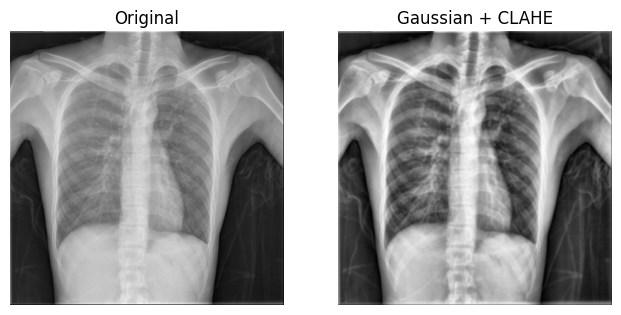

In [5]:
sample_img = cv2.imread(paths_balanced[0], cv2.IMREAD_GRAYSCALE)

pre = preprocess_image(sample_img)


plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(sample_img, cmap="gray"); plt.title("Original"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(pre, cmap="gray"); plt.title("Gaussian + CLAHE"); plt.axis("off")



In [73]:
import cv2
import numpy as np
from scipy import ndimage as ndi

def get_body_mask(img):
    if img.dtype != np.uint8:
        img = np.clip(img, 0, 255).astype(np.uint8)

    h, w = img.shape

    border = int(0.02 * min(h, w))
    work = img.copy()
    work[:border, :] = 0
    work[-border:, :] = 0
    work[:, :border] = 0
    work[:, -border:] = 0

    blur = cv2.GaussianBlur(work, (5, 5), 0)
    _, body_bin = cv2.threshold(
        blur, 0, 255,
        cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )

    k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
    body_bin = cv2.morphologyEx(body_bin, cv2.MORPH_CLOSE, k, iterations=3)

    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(body_bin)

    if num_labels <= 1:
        body_mask = np.zeros_like(img, np.uint8)
        cv2.ellipse(
            body_mask,
            center=(w // 2, int(h * 0.52)),
            axes=(int(w * 0.45), int(h * 0.48)),
            angle=0, startAngle=0, endAngle=360,
            color=1, thickness=-1
        )
        return body_mask

    areas = stats[1:, cv2.CC_STAT_AREA]
    main = 1 + np.argmax(areas)
    body_mask = (labels == main).astype(np.uint8)
    body_mask = ndi.binary_fill_holes(body_mask.astype(bool)).astype(np.uint8)

    return body_mask


def ellipse_from_body(body_mask):
    h, w = body_mask.shape
    ys, xs = np.where(body_mask > 0)

    if len(xs) == 0:
        cx, cy = w // 2, int(h * 0.52)
        rx, ry = int(w * 0.35), int(h * 0.4)
    else:
        x_min, x_max = xs.min(), xs.max()
        y_min, y_max = ys.min(), ys.max()
        w_box = x_max - x_min
        h_box = y_max - y_min
        cx = (x_min + x_max) // 2
        cy = (y_min + y_max) // 2
        rx = int(w_box * 0.4)
        ry = int(h_box * 0.45)

    mask = np.zeros_like(body_mask, np.uint8)
    cv2.ellipse(
        mask,
        center=(cx, cy),
        axes=(rx, ry),
        angle=0, startAngle=0, endAngle=360,
        color=1, thickness=-1
    )
    return mask

def smooth_lung_contour_circle(lung_mask, radius=15):
    """
    Smooth contour paru:
    - proses per connected component (paru kiri & kanan)
    - closing besar + opening sedikit lebih kecil dengan kernel lingkaran
    - cleanup: hanya ambil blob terbesar per paru supaya tonjolan kecil hilang
    radius: kira-kira ukuran gerigi (rib) yang mau dihalusin
    """
    lung_mask_u8 = (lung_mask > 0).astype(np.uint8)

    # pastikan radius masuk akal
    radius = max(int(radius), 1)
    r_close = radius
    r_open  = max(radius // 2, 1)   # opening lebih kecil dari closing

    # kernel lingkaran (ellipse dengan w = h)
    k_close = cv2.getStructuringElement(
        cv2.MORPH_ELLIPSE,
        (2 * r_close + 1, 2 * r_close + 1)
    )
    k_open = cv2.getStructuringElement(
        cv2.MORPH_ELLIPSE,
        (2 * r_open + 1, 2 * r_open + 1)
    )

    num_labels, labels = cv2.connectedComponents(lung_mask_u8)
    out = np.zeros_like(lung_mask_u8)

    for lab in range(1, num_labels):  # skip background
        comp = (labels == lab).astype(np.uint8)

        # 1) closing besar: nutup lembah-lembah di antara tulang
        comp = cv2.morphologyEx(comp, cv2.MORPH_CLOSE, k_close, iterations=1)

        # 2) opening kecil: buang tonjolan kecil di luar paru
        comp = cv2.morphologyEx(comp, cv2.MORPH_OPEN, k_open, iterations=1)

        # 3) cleanup: kalau masih kebentuk beberapa blob, ambil yang terbesar saja
        num2, labels2 = cv2.connectedComponents(comp)
        if num2 > 1:
            areas = []
            for i in range(1, num2):
                areas.append(np.count_nonzero(labels2 == i))
            if areas:
                keep = np.argmax(areas) + 1
                comp = (labels2 == keep).astype(np.uint8)

        out[comp > 0] = 1

    return out.astype(np.uint8)

def limit_to_thorax(mask, h, w):
    """
    Memotong mask ke area thorax tengah:
    - buang bagian atas (leher / tulang bahu yang tinggi)
    - buang sisi kiri/kanan yang terlalu dekat lengan
    - (opsional) buang sedikit bagian paling bawah
    """
    m = mask.copy().astype(np.uint8)

    # buang % bagian atas (clavicle, leher, sebagian bahu)
    top_cut = int(0.08 * h)  # bisa kamu turunkan/naikkan 0.15–0.2
    m[:top_cut, :] = 0

    # buang 5% kiri & kanan (area dekat lengan)
    x_margin = int(0.05 * w)
    m[:, :x_margin] = 0
    m[:, w - x_margin:] = 0

    # opsional: buang 5% terbawah (abdomen)
    bottom_cut = int(0.95 * h)
    m[bottom_cut:, :] = 0

    return m

def segment_lungs_final(img_pre, debug=False):
    """
    Segmentasi paru (lebih natural + closing kecil):
    """
    if img_pre.dtype != np.uint8:
        img = np.clip(img_pre, 0, 255).astype(np.uint8)
    else:
        img = img_pre.copy()

    h, w = img.shape

    body_mask = get_body_mask(img)
    body_mask = limit_to_thorax(body_mask, h, w)
    body_area = body_mask.sum()
    if debug:
        print("body area ratio:", body_area / (h * w + 1e-8))

    img_body = img.copy()
    img_body[body_mask == 0] = 0

    blur = cv2.GaussianBlur(img_body, (5, 5), 0)
    torso_pixels = blur[body_mask == 1].reshape(-1, 1)

    if torso_pixels.size == 0:
        if debug:
            print("torso_pixels kosong -> fallback ellipse lungs")
        lung_mask = ellipse_from_body(body_mask)
        segmented = img * lung_mask
        return segmented, lung_mask

    ret, _ = cv2.threshold(
        torso_pixels, 0, 255,
        cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )
    thresh_val = ret

    _, lung_bin = cv2.threshold(
        blur, thresh_val, 255,
        cv2.THRESH_BINARY_INV
    )
    lung_bin[body_mask == 0] = 0

    k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    lung_bin = cv2.morphologyEx(lung_bin, cv2.MORPH_OPEN, k, iterations=1)
    lung_bin = cv2.morphologyEx(lung_bin, cv2.MORPH_CLOSE, k, iterations=1)

    lung_mask = ndi.binary_fill_holes(lung_bin > 0).astype(np.uint8)
    lung_mask_255 = (lung_mask * 255).astype(np.uint8)

    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(lung_mask_255)
    if debug:
        print("num_labels (lung):", num_labels)

    candidates = []
    for lab in range(1, num_labels):
        area = stats[lab, cv2.CC_STAT_AREA]
        if area < 0.02 * body_area or area > 0.7 * body_area:
            continue
        cx, cy = centroids[lab]
        if not (0.1 * w < cx < 0.9 * w and 0.15 * h < cy < 0.95 * h):
            continue
        candidates.append((area, lab))

    if len(candidates) >= 1:
        candidates.sort(reverse=True, key=lambda x: x[0])
        chosen = [lab for _, lab in candidates[:2]]
        lung_mask = np.isin(labels, chosen).astype(np.uint8)
    else:
        if debug:
            print("tidak ada kandidat yang wajar → fallback ellipse")
        lung_mask = ellipse_from_body(body_mask)

    # hanya di dalam body
    lung_mask = (lung_mask.astype(np.uint8) & body_mask.astype(np.uint8))

    # smoothing ringan
    lung_mask = smooth_lung_contour_circle(lung_mask, radius=8)

    # isi lubang
    lung_mask = ndi.binary_fill_holes(lung_mask > 0).astype(np.uint8)

    # --- EXTRA 1: erode kecil + closing/dilasi kecil ---
    erode_r = 1
    k_erode = cv2.getStructuringElement(
        cv2.MORPH_ELLIPSE,
        (2 * erode_r + 1, 2 * erode_r + 1)
    )
    lung_mask = cv2.erode(lung_mask.astype(np.uint8), k_erode, iterations=1)
    lung_mask = ndi.binary_fill_holes(lung_mask > 0).astype(np.uint8)

    # closing kecil untuk nutup celah tipis tanpa bikin ellips
    close_r = 1   # bisa naikin ke 2 kalau masih banyak celah halus
    k_close_small = cv2.getStructuringElement(
        cv2.MORPH_ELLIPSE,
        (2 * close_r + 1, 2 * close_r + 1)
    )
    lung_mask = cv2.morphologyEx(lung_mask.astype(np.uint8),
                                 cv2.MORPH_CLOSE,
                                 k_close_small,
                                 iterations=1)
    lung_mask = ndi.binary_fill_holes(lung_mask > 0).astype(np.uint8)
    # ----------------------------------------------

    num_l, labels_l, stats_l, cents_l = cv2.connectedComponentsWithStats(
        lung_mask.astype(np.uint8)
    )

    if num_l > 1:
        areas = stats_l[1:, cv2.CC_STAT_AREA]
        order = np.argsort(areas)[::-1]
        top2 = order[:2] + 1

        valid_labels = []
        for lab in top2:
            cx, cy = cents_l[lab]
            if 0.1 * w < cx < 0.9 * w and 0.20 * h < cy < 0.95 * h:
                valid_labels.append(lab)

        if len(valid_labels) == 0:
            valid_labels = list(top2)

        lung_mask = np.isin(labels_l, valid_labels).astype(np.uint8)

    lung_area_ratio = lung_mask.sum() / (h * w + 1e-8)
    if debug:
        print("lung area ratio:", lung_area_ratio)

    segmented = img * lung_mask
    return segmented, lung_mask


body area ratio: 0.630298614501929
num_labels (lung): 31
lung area ratio: 0.20503234863280467
mask sum: 53748


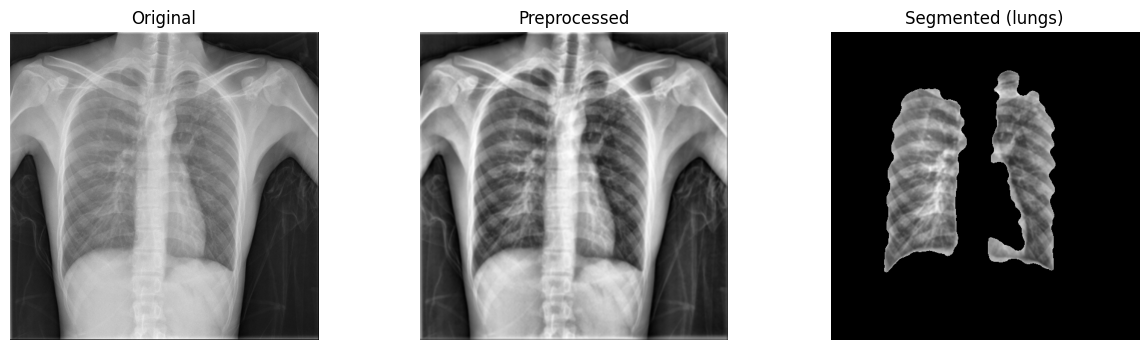

mask sum: 82667


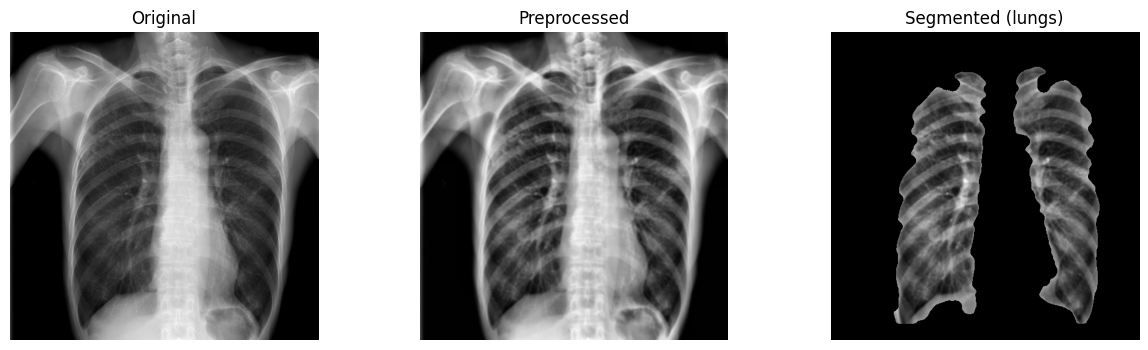

mask sum: 71219


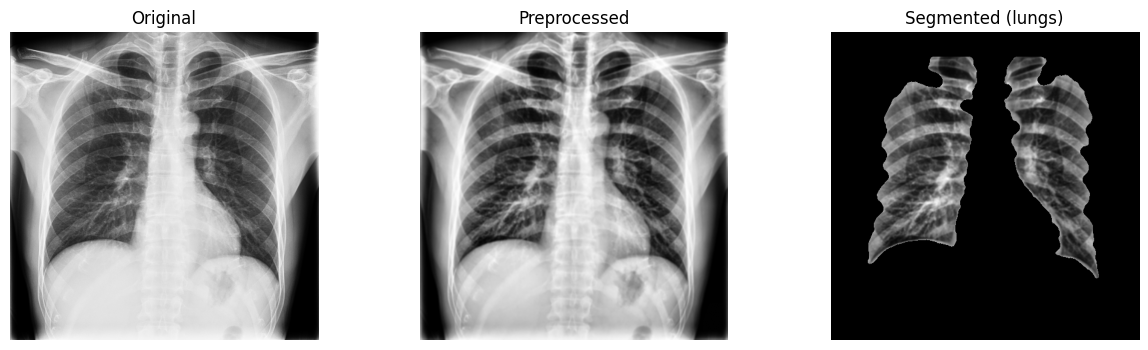

mask sum: 80322


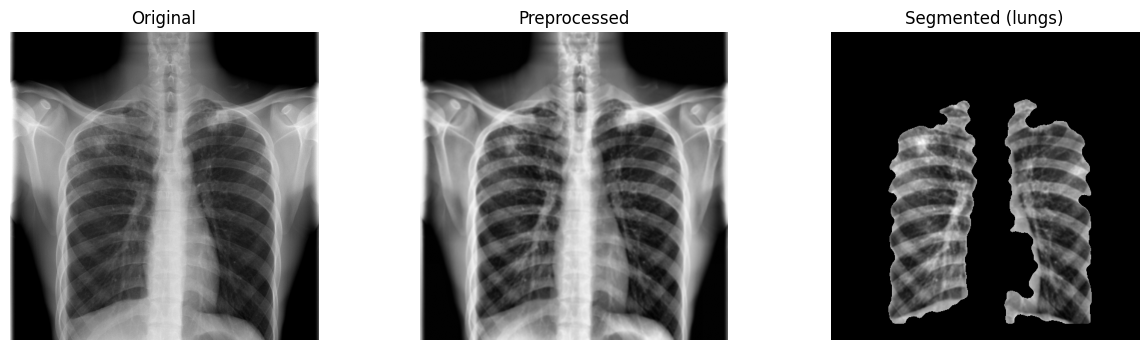

mask sum: 74234


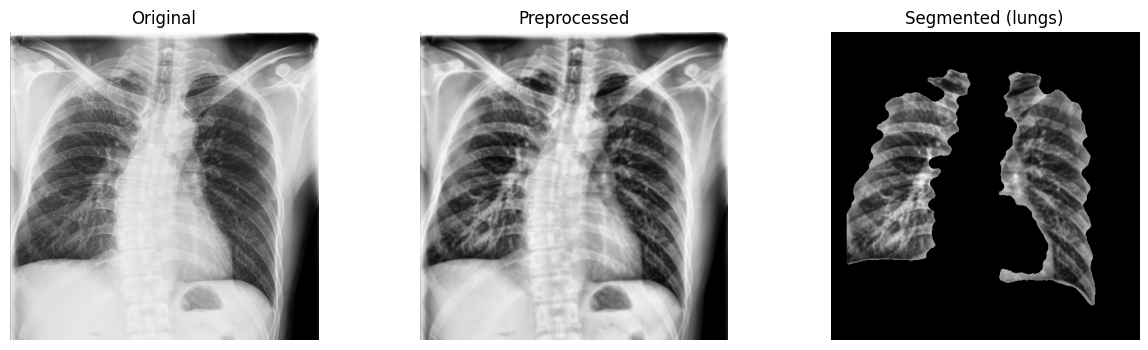

mask sum: 41211


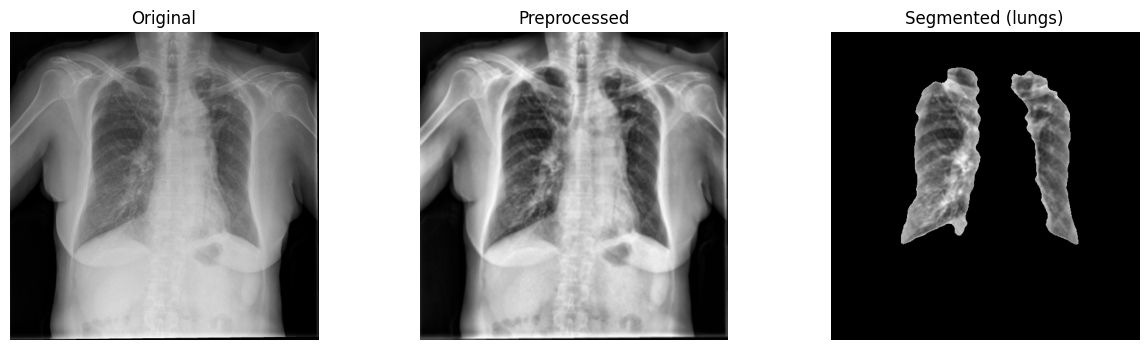

mask sum: 52540


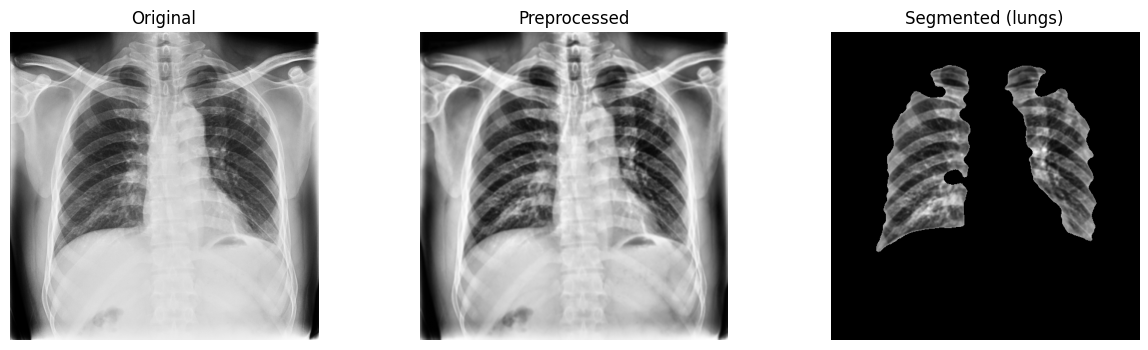

mask sum: 52424


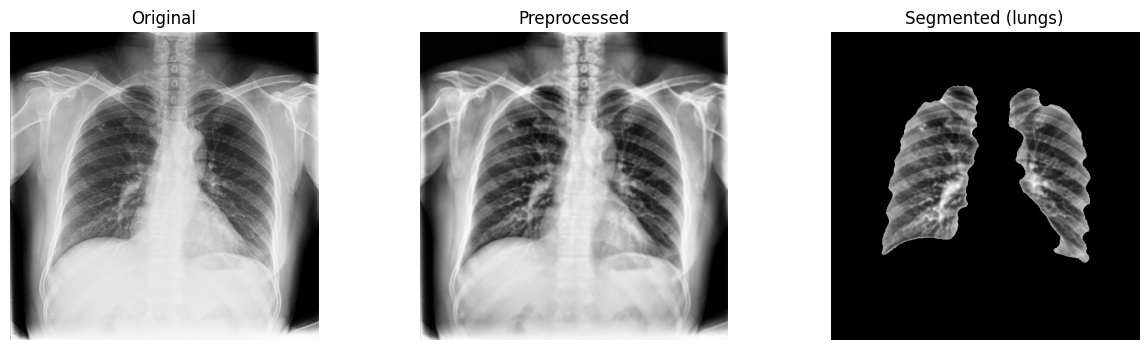

mask sum: 53339


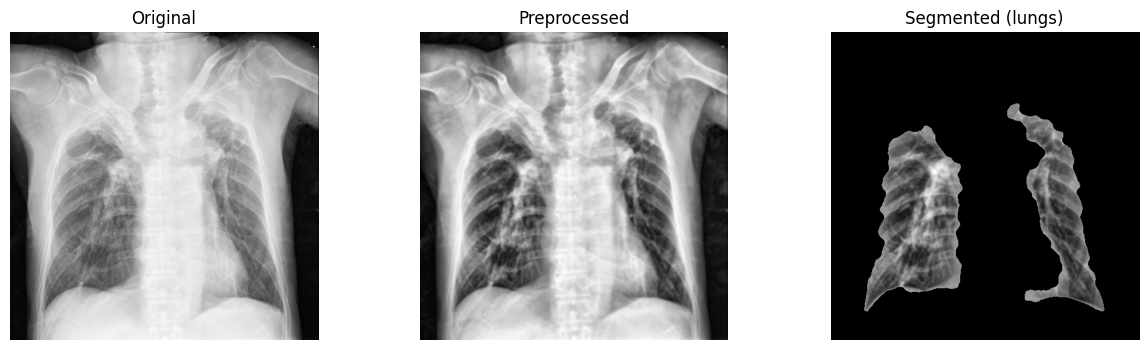

In [74]:
sample_img = cv2.imread(paths_balanced[0], cv2.IMREAD_GRAYSCALE)

pre = preprocess_image(sample_img)
seg, mask = segment_lungs_final(pre, debug=True)

print("mask sum:", mask.sum())

plt.figure(figsize=(15,4))
plt.subplot(1,3,1); plt.imshow(sample_img, cmap="gray"); plt.title("Original"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(pre, cmap="gray"); plt.title("Preprocessed"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(seg, cmap="gray"); plt.title("Segmented (lungs)"); plt.axis("off")
plt.show()

sample_img = cv2.imread(paths_balanced[1], cv2.IMREAD_GRAYSCALE)

pre = preprocess_image(sample_img)
seg, mask = segment_lungs_final(pre)

print("mask sum:", mask.sum())

plt.figure(figsize=(15,4))
plt.subplot(1,3,1); plt.imshow(sample_img, cmap="gray"); plt.title("Original"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(pre, cmap="gray"); plt.title("Preprocessed"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(seg, cmap="gray"); plt.title("Segmented (lungs)"); plt.axis("off")
plt.show()


sample_img = cv2.imread(paths_balanced[2], cv2.IMREAD_GRAYSCALE)

pre = preprocess_image(sample_img)
seg, mask = segment_lungs_final(pre)

print("mask sum:", mask.sum())

plt.figure(figsize=(15,4))
plt.subplot(1,3,1); plt.imshow(sample_img, cmap="gray"); plt.title("Original"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(pre, cmap="gray"); plt.title("Preprocessed"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(seg, cmap="gray"); plt.title("Segmented (lungs)"); plt.axis("off")
plt.show()

sample_img = cv2.imread(paths_balanced[3], cv2.IMREAD_GRAYSCALE)

pre = preprocess_image(sample_img)
seg, mask = segment_lungs_final(pre)

print("mask sum:", mask.sum())

plt.figure(figsize=(15,4))
plt.subplot(1,3,1); plt.imshow(sample_img, cmap="gray"); plt.title("Original"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(pre, cmap="gray"); plt.title("Preprocessed"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(seg, cmap="gray"); plt.title("Segmented (lungs)"); plt.axis("off")
plt.show()

sample_img = cv2.imread(paths_balanced[4], cv2.IMREAD_GRAYSCALE)

pre = preprocess_image(sample_img)
seg, mask = segment_lungs_final(pre)

print("mask sum:", mask.sum())

plt.figure(figsize=(15,4))
plt.subplot(1,3,1); plt.imshow(sample_img, cmap="gray"); plt.title("Original"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(pre, cmap="gray"); plt.title("Preprocessed"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(seg, cmap="gray"); plt.title("Segmented (lungs)"); plt.axis("off")
plt.show()


sample_img = cv2.imread(paths_balanced[5], cv2.IMREAD_GRAYSCALE)

pre = preprocess_image(sample_img)
seg, mask = segment_lungs_final(pre)

print("mask sum:", mask.sum())

plt.figure(figsize=(15,4))
plt.subplot(1,3,1); plt.imshow(sample_img, cmap="gray"); plt.title("Original"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(pre, cmap="gray"); plt.title("Preprocessed"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(seg, cmap="gray"); plt.title("Segmented (lungs)"); plt.axis("off")
plt.show()

sample_img = cv2.imread(paths_balanced[6], cv2.IMREAD_GRAYSCALE)

pre = preprocess_image(sample_img)
seg, mask = segment_lungs_final(pre)

print("mask sum:", mask.sum())

plt.figure(figsize=(15,4))
plt.subplot(1,3,1); plt.imshow(sample_img, cmap="gray"); plt.title("Original"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(pre, cmap="gray"); plt.title("Preprocessed"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(seg, cmap="gray"); plt.title("Segmented (lungs)"); plt.axis("off")
plt.show()

sample_img = cv2.imread(paths_balanced[7], cv2.IMREAD_GRAYSCALE)

pre = preprocess_image(sample_img)
seg, mask = segment_lungs_final(pre)

print("mask sum:", mask.sum())

plt.figure(figsize=(15,4))
plt.subplot(1,3,1); plt.imshow(sample_img, cmap="gray"); plt.title("Original"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(pre, cmap="gray"); plt.title("Preprocessed"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(seg, cmap="gray"); plt.title("Segmented (lungs)"); plt.axis("off")
plt.show()


sample_img = cv2.imread(paths_balanced[8], cv2.IMREAD_GRAYSCALE)

pre = preprocess_image(sample_img)
seg, mask = segment_lungs_final(pre)

print("mask sum:", mask.sum())

plt.figure(figsize=(15,4))
plt.subplot(1,3,1); plt.imshow(sample_img, cmap="gray"); plt.title("Original"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(pre, cmap="gray"); plt.title("Preprocessed"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(seg, cmap="gray"); plt.title("Segmented (lungs)"); plt.axis("off")
plt.show()



In [86]:
# ============================================================
# 6. Ekstraksi fitur: GLCM + PCA
# ============================================================
from skimage.feature import graycomatrix, graycoprops

def glcm_features(img,
                  distances=(1, 2, 4),
                  angles=(0, np.pi/4, np.pi/2, 3*np.pi/4),
                  levels=16):
    """
    Ekstraksi fitur GLCM:
    - quantisasi ke 'levels' gray level
    - untuk setiap prop GLCM, simpan SEMUA nilai untuk setiap (distance, angle)
      => 6 * len(distances) * len(angles) fitur
    """
    # pastikan uint8
    if img.dtype != np.uint8:
        img = np.clip(img, 0, 255).astype(np.uint8)

    # Quantize ke 0..levels-1
    img_q = (img / (256 // levels)).astype(np.uint8)

    glcm = graycomatrix(
        img_q,
        distances=distances,
        angles=angles,
        levels=levels,
        symmetric=True,
        normed=True
    )

    props = ["contrast", "dissimilarity", "homogeneity",
             "energy", "correlation", "ASM"]

    feat = []
    for prop in props:
        values = graycoprops(glcm, prop)   # shape: [len(distances), len(angles)]
        feat.extend(values.flatten())      # simpan SEMUA kombinasi jarak×sudut

    return np.array(feat, dtype=np.float32)


# Test 1 gambar
test_feat = glcm_features(seg)
print("Panjang vektor fitur GLCM:", test_feat.shape[0])

def glcm_stat_features(img,
                       distances=(1, 2, 4),
                       angles=(0, np.pi/4, np.pi/2, 3*np.pi/4),
                       levels=16):
    """
    Ekstraksi fitur:
    - 6 fitur GLCM: contrast, dissimilarity, homogeneity, energy, correlation, ASM
      -> disimpan SEMUA nilai untuk setiap (distance, angle)
         => 6 * len(distances) * len(angles) fitur
    - 8 fitur statistik intensitas: mean, std, entropy, RMS, variance, smoothness, kurtosis, skewness

    img: hasil segmentasi paru (seg_img), uint8 (0..255)
    return: vektor fitur 1D (float32)
    """

    # pastikan uint8
    if img.dtype != np.uint8:
        img = np.clip(img, 0, 255).astype(np.uint8)

    h, w = img.shape

    # ==========================
    # 1) STATISTICAL FEATURES (8)
    # ==========================
    roi_vals = img[img > 0].astype(np.float32)  # hanya piksel paru (mask != 0)
    if roi_vals.size == 0:
        roi_vals = img.reshape(-1).astype(np.float32)

    mean_val = roi_vals.mean()
    std_val  = roi_vals.std()

    # entropy dari histogram
    hist, _ = np.histogram(roi_vals, bins=levels, range=(0, 255), density=True)
    hist = hist + 1e-12
    entropy = -np.sum(hist * np.log2(hist))

    # RMS & variance
    rms = np.sqrt(np.mean((roi_vals - mean_val) ** 2))
    variance = std_val ** 2

    # smoothness: 1 - 1/(1 + σ²)
    smoothness = 1.0 - 1.0 / (1.0 + variance)

    # kurtosis & skewness
    if std_val > 1e-6:
        z = (roi_vals - mean_val) / std_val
        kurtosis = np.mean(z**4) - 3.0
        skewness = np.mean(z**3)
    else:
        kurtosis = 0.0
        skewness = 0.0

    stat_feats = [
        mean_val, std_val, entropy, rms,
        variance, smoothness, kurtosis, skewness
    ]

    # ==========================
    # 2) GLCM FEATURES (6 × D × A)
    # ==========================
    # quantisasi
    step = max(256 // levels, 1)
    img_q = (img // step).astype(np.uint8)

    # bisa pakai bounding box paru biar GLCM tidak didominasi background
    ys, xs = np.where(img > 0)
    if len(xs) > 0:
        y_min, y_max = ys.min(), ys.max()
        x_min, x_max = xs.min(), xs.max()
        img_q_sub = img_q[y_min:y_max+1, x_min:x_max+1]
    else:
        img_q_sub = img_q

    glcm = graycomatrix(
        img_q_sub,
        distances=distances,
        angles=angles,
        levels=levels,
        symmetric=True,
        normed=True
    )

    props = ["contrast", "correlation", "homogeneity",
             "energy", "entropy", "variance"]

    glcm_feats = []
    for p in props:
        vals = graycoprops(glcm, p)   # shape: [len(distances), len(angles)]
        glcm_feats.extend(vals.flatten())  # SIMPAN semua jarak × sudut

    # gabungkan: [GLCM per d×θ] + [8 statistik]
    feats = np.array(glcm_feats + stat_feats, dtype=np.float32)
    return feats



Panjang vektor fitur GLCM: 72


In [87]:
# ============================================================
# 7. Bangun dataset fitur untuk semua gambar
# ============================================================

X_features = []
y_labels = []

for path, label in tqdm(zip(paths_balanced, labels_balanced), total=len(paths_balanced)):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        continue

    pre_img = preprocess_image(img)
    seg_img, _ = segment_lungs_final(pre_img)

    feat = glcm_stat_features(seg_img)   # <- SEpKARANG sudah include jarak×sudut
    X_features.append(feat)
    y_labels.append(label)

X_features = np.vstack(X_features)
y_labels = np.array(y_labels)

print("Shape fitur:", X_features.shape)
print("Shape label:", y_labels.shape)


100%|██████████| 2000/2000 [04:01<00:00,  8.30it/s]

Shape fitur: (2000, 80)
Shape label: (2000,)


In [88]:
# ============================================================
# 8. Train-test split, standardisasi, PCA, dan SVM
# ============================================================

X_train, X_test, y_train, y_test = train_test_split(
    X_features,
    y_labels,
    test_size=0.2,
    random_state=42,
    stratify=y_labels
)

# Standardisasi
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

# PCA (Feature Optimization)
pca = PCA(n_components=0.95, random_state=42)  # simpan 95% varian
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

print("Dimensi awal:", X_train_std.shape[1])
print("Dimensi setelah PCA:", X_train_pca.shape[1])

# SVM classifier
svm_clf = SVC(
    kernel="rbf",
    C=10,
    gamma="scale",
    probability=False,
    class_weight="balanced",
    random_state=42
)

svm_clf.fit(X_train_pca, y_train)
y_pred = svm_clf.predict(X_test_pca)


Dimensi awal: 80
Dimensi setelah PCA: 5


In [89]:
# ============================================================
# 9. Evaluasi: Confusion Matrix, Accuracy, Sensitivity, Specificity
# ============================================================

cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

accuracy = accuracy_score(y_test, y_pred)
sensitivity = tp / (tp + fn)  # recall untuk kelas TB (1)
specificity = tn / (tn + fp)  # recall untuk kelas Non-TB (0)

print("Confusion Matrix:\n", cm)
print(f"\nAccuracy   : {accuracy:.4f}")
print(f"Sensitivity (Recall TB)   : {sensitivity:.4f}")
print(f"Specificity (Recall Non-TB): {specificity:.4f}")

Confusion Matrix:
 [[209  31]
 [ 32 128]]

Accuracy   : 0.8425
Sensitivity (Recall TB)   : 0.8000
Specificity (Recall Non-TB): 0.8708


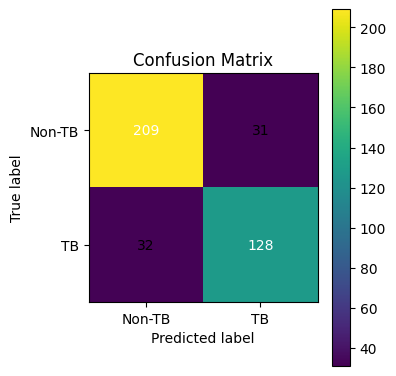

In [90]:
# Visualisasi confusion matrix sederhana
fig, ax = plt.subplots(figsize=(4, 4))
im = ax.imshow(cm, interpolation="nearest")
ax.set_title("Confusion Matrix")
plt.colorbar(im, ax=ax)
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(["Non-TB", "TB"])
ax.set_yticklabels(["Non-TB", "TB"])
plt.xlabel("Predicted label")
plt.ylabel("True label")

# Tampilkan angka di tiap cell
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(
            j, i, format(cm[i, j], "d"),
            ha="center", va="center",
            color="white" if cm[i, j] > thresh else "black"
        )
plt.tight_layout()
plt.show()

In [91]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, recall_score, accuracy_score, confusion_matrix
import numpy as np

# 1) Split train–test
X_train, X_test, y_train, y_test = train_test_split(
    X_features,
    y_labels,
    test_size=0.2,
    random_state=42,
    stratify=y_labels
)

# ---------------------------------------------------
# 2) CROSS-VALIDATION di TRAIN SET
#    (supaya tidak leak ke test)
# ---------------------------------------------------
# Di sini kita pakai pipeline biar scaling & PCA terjadi di dalam tiap fold CV
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("svm", SVC(
        kernel="rbf",
        C=10,
        gamma="scale",
        class_weight="balanced",
        random_state=42
    ))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    "accuracy": "accuracy",
    "sensitivity": make_scorer(recall_score, pos_label=1),
    "specificity": make_scorer(recall_score, pos_label=0),
}

cv_results = cross_validate(
    pipe,
    X_train,
    y_train,
    cv=cv,
    scoring=scoring,
    n_jobs=-1,
    return_train_score=False
)

print("=== 5-FOLD CV ON TRAIN SET ===")
print(f"Accuracy   : {cv_results['test_accuracy'].mean():.4f} ± {cv_results['test_accuracy'].std():.4f}")
print(f"Sensitivity: {cv_results['test_sensitivity'].mean():.4f} ± {cv_results['test_sensitivity'].std():.4f}")
print(f"Specificity: {cv_results['test_specificity'].mean():.4f} ± {cv_results['test_specificity'].std():.4f}")
print()

# ---------------------------------------------------
# 3) Train FINAL model
#    di seluruh X_train, lalu evaluasi TRAIN & TEST
# ---------------------------------------------------

# Standardisasi
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std  = scaler.transform(X_test)

# PCA
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca  = pca.transform(X_test_std)

print("Dimensi awal:", X_train_std.shape[1])
print("Dimensi setelah PCA:", X_train_pca.shape[1])

# SVM classifier
svm_clf = SVC(
    kernel="rbf",
    C=10,
    gamma="scale",
    probability=False,
    class_weight="balanced",
    random_state=42
)

svm_clf.fit(X_train_pca, y_train)

# ===== TRAIN PERFORMANCE =====
y_train_pred = svm_clf.predict(X_train_pca)
cm_tr = confusion_matrix(y_train, y_train_pred)
tn_tr, fp_tr, fn_tr, tp_tr = cm_tr.ravel()

acc_tr  = accuracy_score(y_train, y_train_pred)
sens_tr = tp_tr / (tp_tr + fn_tr + 1e-12)
spec_tr = tn_tr / (tn_tr + fp_tr + 1e-12)

print("=== TRAIN PERFORMANCE ===")
print("Confusion Matrix (Train):\n", cm_tr)
print(f"Accuracy (Train)              : {acc_tr:.4f}")
print(f"Sensitivity (Recall TB, Train): {sens_tr:.4f}")
print(f"Specificity (Recall Non-TB)   : {spec_tr:.4f}\n")

# ===== TEST PERFORMANCE =====
y_test_pred = svm_clf.predict(X_test_pca)
cm_te = confusion_matrix(y_test, y_test_pred)
tn, fp, fn, tp = cm_te.ravel()

acc_te  = accuracy_score(y_test, y_test_pred)
sens_te = tp / (tp + fn + 1e-12)
spec_te = tn / (tn + fp + 1e-12)

print("=== TEST PERFORMANCE ===")
print("Confusion Matrix (Test):\n", cm_te)
print(f"Accuracy (Test)               : {acc_te:.4f}")
print(f"Sensitivity (Recall TB, Test) : {sens_te:.4f}")
print(f"Specificity (Recall Non-TB)   : {spec_te:.4f}")

=== 5-FOLD CV ON TRAIN SET ===
Accuracy   : 0.8337 ± 0.0096
Sensitivity: 0.8172 ± 0.0286
Specificity: 0.8448 ± 0.0051

Dimensi awal: 80
Dimensi setelah PCA: 5
=== TRAIN PERFORMANCE ===
Confusion Matrix (Train):
 [[841 119]
 [ 74 566]]
Accuracy (Train)              : 0.8794
Sensitivity (Recall TB, Train): 0.8844
Specificity (Recall Non-TB)   : 0.8760

=== TEST PERFORMANCE ===
Confusion Matrix (Test):
 [[209  31]
 [ 32 128]]
Accuracy (Test)               : 0.8425
Sensitivity (Recall TB, Test) : 0.8000
Specificity (Recall Non-TB)   : 0.8708
